In [2]:
### Colab Notebook: Stable Diffusion vs. ControlNet (Edge Conditioning)

# Install required libraries
!pip install diffusers transformers accelerate torch safetensors opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 17.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 60.0 MB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.1/342.1 KB 108.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.1/450.1 KB 106.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 133.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.0/468.0 KB 128.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 782.5/782.5 KB 176.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 KB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 224.9 MB/s eta 0:00:00


In [23]:
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionControlNetPipeline, ControlNetModel
from diffusers.utils import load_image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageOps
from tqdm import tqdm

In [4]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA is available. PyTorch will use the GPU.')
    print('Device name:', torch.cuda.get_device_name(0)) # Get GPU name
    print('Number of GPUs available:', torch.cuda.device_count())
else:
    device = torch.device('cpu')
    print('CUDA is not available. PyTorch will use the CPU.')

CUDA is available. PyTorch will use the GPU.
Device name: NVIDIA GH200 480GB
Number of GPUs available: 1


In [17]:
# Load Stable Diffusion (without conditioning)
pipeline = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to("cuda")

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 12.23it/s]


In [5]:
# Load ControlNet Model
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny").to("cuda")
pipeline_controlnet = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet
).to("cuda")

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 11.91it/s]


In [43]:
# Load sample image and apply Canny Edge Detection
# image_path = "DEM_Images/mars_dem_random_25.png"
image_path = "../dem-controlnet/sample_images/rugged-rocky-terrain-stockcake.jpg"
original_image = load_image(image_path)
gray_image = cv2.cvtColor(np.array(original_image), cv2.COLOR_RGB2GRAY)
edge_image = cv2.Canny(gray_image, 100, 200)

In [46]:
# Load DEM image as grayscale
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply edge detection (Canny)
edges = cv2.Canny(original_image, 50, 150)  # Adjust thresholds if needed
edge_image = Image.fromarray(edges)  # Convert back to PIL Image

# Optional: Invert edges for better contrast
edge_image = ImageOps.invert(edge_image)

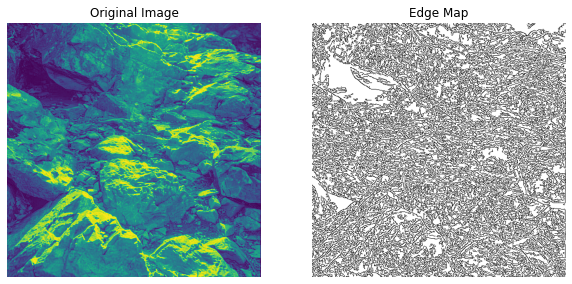

In [47]:
# Display original and edge-detected image
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(edge_image, cmap="gray")
plt.title("Edge Map")
plt.axis("off")
plt.show()

In [31]:
def generate_diffusion_image(prompt, image):
    # Convert single-channel grayscale to 3-channel format
    image_rgb = np.stack([image] * 3, axis=-1)  # Replicate across RGB channels

    # Convert to tensor
    image_tensor = torch.tensor(image_rgb).permute(2, 0, 1).unsqueeze(0).float() / 255.0
    image_tensor = image_tensor.to(device="cuda", dtype=torch.float16)

    # Generate image using ControlNet
    image = pipeline(prompt, image=image_tensor).images[0]
    return image
    
def generate_controlnet_image(prompt, image):
    # Convert single-channel grayscale to 3-channel format
    image_rgb = np.stack([image] * 3, axis=-1)  # Replicate across RGB channels

    # Convert to tensor
    image_tensor = torch.tensor(image_rgb).permute(2, 0, 1).unsqueeze(0).float() / 255.0
    image_tensor = image_tensor.to(device="cuda", dtype=torch.float16)

    # Generate image using ControlNet
    image = pipeline_controlnet(prompt, image=image_tensor).images[0]
    return image

In [48]:
# Define the prompt for generation
prompt = "A deep crater on the Martian surface with steep cliffs and scattered boulders."
# prompt = "A crater on an imaginary rocky planet's surface with steep cliffs and scattered boulders."

In [55]:
# Ensure ControlNet image output folder exists
controlnet_output_dir = "sample_output_dir"
os.makedirs(controlnet_output_dir, exist_ok=True)

# Get all DEM images
dem_folder = "../dem-controlnet/DEM_Images_750x750"
dem_images = [f for f in os.listdir(dem_folder)]

# Process each DEM image through ControlNet with tqdm progress bar
for i, dem_image in enumerate(tqdm(dem_images, desc="Generating ControlNet Images", unit="image")):
    dem_path = os.path.join(dem_folder, dem_image)
    original_image = cv2.imread(dem_path, cv2.IMREAD_GRAYSCALE)
    
    # Apply Histogram Equalization to enhance contrast
    equalized = cv2.equalizeHist(original_image)
    
    # Now apply Canny edge detection
    edges = cv2.Canny(equalized, 30, 100)  # Adjust thresholds

    # Apply edge detection (Canny)
    edge_image = Image.fromarray(edges)  # Convert back to PIL Image
    
    # Generate an image with ControlNet
    generated_image = generate_controlnet_image(prompt, edge_image)
    
    # Save the output image
    output_path = os.path.join(controlnet_output_dir, f"controlnet_generated_{i+1}.png")
    generated_image.save(output_path)

    tqdm.write(f"Saved ControlNet output: {output_path}")

Generating ControlNet Images:   0%|          | 0/30 [00:00<?, ?image/s]
%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:15,  3.23it/s]
%|▍         | 2/50 [00:00<00:10,  4.66it/s]
%|▌         | 3/50 [00:00<00:08,  5.43it/s]
%|▊         | 4/50 [00:00<00:07,  5.88it/s]
%|█         | 5/50 [00:00<00:07,  6.18it/s]
%|█▏        | 6/50 [00:01<00:06,  6.36it/s]
%|█▍        | 7/50 [00:01<00:06,  6.49it/s]
%|█▌        | 8/50 [00:01<00:06,  6.58it/s]
%|█▊        | 9/50 [00:01<00:06,  6.64it/s]
%|██        | 10/50 [00:01<00:05,  6.67it/s]
%|██▏       | 11/50 [00:01<00:05,  6.70it/s]
%|██▍       | 12/50 [00:01<00:05,  6.72it/s]
%|██▌       | 13/50 [00:02<00:05,  6.73it/s]
%|██▊       | 14/50 [00:02<00:05,  6.74it/s]
%|███       | 15/50 [00:02<00:05,  6.75it/s]
%|███▏      | 16/50 [00:02<00:05,  6.75it/s]
%|███▍      | 17/50 [00:02<00:04,  6.75it/s]
%|███▌      | 18/50 [00:02<00:04,  6.76it/s]
%|███▊      | 19/50 [00:02<00:04,  6.76it/s]
%|████      | 20/50 [00:03<00:04,  6.76it/s]
%

Saved ControlNet output: sample_output_dir/controlnet_generated_1.png



%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:14,  3.39it/s]
%|▍         | 2/50 [00:00<00:10,  4.80it/s]
%|▌         | 3/50 [00:00<00:08,  5.54it/s]
%|▊         | 4/50 [00:00<00:07,  5.96it/s]
%|█         | 5/50 [00:00<00:07,  6.23it/s]
%|█▏        | 6/50 [00:01<00:06,  6.40it/s]
%|█▍        | 7/50 [00:01<00:06,  6.52it/s]
%|█▌        | 8/50 [00:01<00:06,  6.59it/s]
%|█▊        | 9/50 [00:01<00:06,  6.64it/s]
%|██        | 10/50 [00:01<00:05,  6.68it/s]
%|██▏       | 11/50 [00:01<00:05,  6.71it/s]
%|██▍       | 12/50 [00:01<00:05,  6.72it/s]
%|██▌       | 13/50 [00:02<00:05,  6.73it/s]
%|██▊       | 14/50 [00:02<00:05,  6.75it/s]
%|███       | 15/50 [00:02<00:05,  6.75it/s]
%|███▏      | 16/50 [00:02<00:05,  6.76it/s]
%|███▍      | 17/50 [00:02<00:04,  6.76it/s]
%|███▌      | 18/50 [00:02<00:04,  6.76it/s]
%|███▊      | 19/50 [00:02<00:04,  6.76it/s]
%|████      | 20/50 [00:03<00:04,  6.76it/s]
%|████▏     | 21/50 [00:03<00:04,  6.76it/s]
%|████▍     | 22/50 [00:03<

Saved ControlNet output: sample_output_dir/controlnet_generated_2.png



%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:14,  3.40it/s]
%|▍         | 2/50 [00:00<00:09,  4.81it/s]
%|▌         | 3/50 [00:00<00:08,  5.53it/s]
%|▊         | 4/50 [00:00<00:07,  5.96it/s]
%|█         | 5/50 [00:00<00:07,  6.23it/s]
%|█▏        | 6/50 [00:01<00:06,  6.40it/s]
%|█▍        | 7/50 [00:01<00:06,  6.52it/s]
%|█▌        | 8/50 [00:01<00:06,  6.59it/s]
%|█▊        | 9/50 [00:01<00:06,  6.65it/s]
%|██        | 10/50 [00:01<00:05,  6.69it/s]
%|██▏       | 11/50 [00:01<00:05,  6.71it/s]
%|██▍       | 12/50 [00:01<00:05,  6.73it/s]
%|██▌       | 13/50 [00:02<00:05,  6.74it/s]
%|██▊       | 14/50 [00:02<00:05,  6.75it/s]
%|███       | 15/50 [00:02<00:05,  6.75it/s]
%|███▏      | 16/50 [00:02<00:05,  6.76it/s]
%|███▍      | 17/50 [00:02<00:04,  6.76it/s]
%|███▌      | 18/50 [00:02<00:04,  6.76it/s]
%|███▊      | 19/50 [00:02<00:04,  6.76it/s]
%|████      | 20/50 [00:03<00:04,  6.76it/s]
%|████▏     | 21/50 [00:03<00:04,  6.76it/s]
%|████▍     | 22/50 [00:03<

Saved ControlNet output: sample_output_dir/controlnet_generated_3.png



%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:14,  3.39it/s]
%|▍         | 2/50 [00:00<00:10,  4.80it/s]
%|▌         | 3/50 [00:00<00:08,  5.53it/s]
%|▊         | 4/50 [00:00<00:07,  5.96it/s]
%|█         | 5/50 [00:00<00:07,  6.23it/s]
%|█▏        | 6/50 [00:01<00:06,  6.40it/s]
%|█▍        | 7/50 [00:01<00:06,  6.52it/s]
%|█▌        | 8/50 [00:01<00:06,  6.59it/s]
%|█▊        | 9/50 [00:01<00:06,  6.65it/s]
%|██        | 10/50 [00:01<00:05,  6.68it/s]
%|██▏       | 11/50 [00:01<00:05,  6.71it/s]
%|██▍       | 12/50 [00:01<00:05,  6.73it/s]
%|██▌       | 13/50 [00:02<00:05,  6.74it/s]
%|██▊       | 14/50 [00:02<00:05,  6.75it/s]
%|███       | 15/50 [00:02<00:05,  6.75it/s]
%|███▏      | 16/50 [00:02<00:05,  6.75it/s]
%|███▍      | 17/50 [00:02<00:04,  6.76it/s]
%|███▌      | 18/50 [00:02<00:04,  6.76it/s]
%|███▊      | 19/50 [00:02<00:04,  6.76it/s]
%|████      | 20/50 [00:03<00:04,  6.77it/s]
%|████▏     | 21/50 [00:03<00:04,  6.77it/s]
%|████▍     | 22/50 [00:03<

Saved ControlNet output: sample_output_dir/controlnet_generated_4.png



%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:14,  3.40it/s]
%|▍         | 2/50 [00:00<00:09,  4.81it/s]
%|▌         | 3/50 [00:00<00:08,  5.54it/s]
%|▊         | 4/50 [00:00<00:07,  5.97it/s]
%|█         | 5/50 [00:00<00:07,  6.23it/s]
%|█▏        | 6/50 [00:01<00:06,  6.41it/s]
%|█▍        | 7/50 [00:01<00:06,  6.52it/s]
%|█▌        | 8/50 [00:01<00:06,  6.60it/s]
%|█▊        | 9/50 [00:01<00:06,  6.65it/s]
%|██        | 10/50 [00:01<00:05,  6.69it/s]
%|██▏       | 11/50 [00:01<00:05,  6.71it/s]
%|██▍       | 12/50 [00:01<00:05,  6.73it/s]
%|██▌       | 13/50 [00:02<00:05,  6.74it/s]
%|██▊       | 14/50 [00:02<00:05,  6.75it/s]
%|███       | 15/50 [00:02<00:05,  6.75it/s]
%|███▏      | 16/50 [00:02<00:05,  6.76it/s]
%|███▍      | 17/50 [00:02<00:04,  6.76it/s]
%|███▌      | 18/50 [00:02<00:04,  6.77it/s]
%|███▊      | 19/50 [00:02<00:04,  6.77it/s]
%|████      | 20/50 [00:03<00:04,  6.77it/s]
%|████▏     | 21/50 [00:03<00:04,  6.77it/s]
%|████▍     | 22/50 [00:03<

Saved ControlNet output: sample_output_dir/controlnet_generated_5.png



%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:14,  3.41it/s]
%|▍         | 2/50 [00:00<00:09,  4.81it/s]
%|▌         | 3/50 [00:00<00:08,  5.54it/s]
%|▊         | 4/50 [00:00<00:07,  5.97it/s]
%|█         | 5/50 [00:00<00:07,  6.24it/s]
%|█▏        | 6/50 [00:01<00:06,  6.41it/s]
%|█▍        | 7/50 [00:01<00:06,  6.53it/s]
%|█▌        | 8/50 [00:01<00:06,  6.60it/s]
%|█▊        | 9/50 [00:01<00:06,  6.66it/s]
%|██        | 10/50 [00:01<00:05,  6.69it/s]
%|██▏       | 11/50 [00:01<00:05,  6.71it/s]
%|██▍       | 12/50 [00:01<00:05,  6.73it/s]
%|██▌       | 13/50 [00:02<00:05,  6.74it/s]
%|██▊       | 14/50 [00:02<00:05,  6.75it/s]
%|███       | 15/50 [00:02<00:05,  6.75it/s]
%|███▏      | 16/50 [00:02<00:05,  6.76it/s]
%|███▍      | 17/50 [00:02<00:04,  6.76it/s]
%|███▌      | 18/50 [00:02<00:04,  6.76it/s]
%|███▊      | 19/50 [00:02<00:04,  6.77it/s]
%|████      | 20/50 [00:03<00:04,  6.77it/s]
%|████▏     | 21/50 [00:03<00:04,  6.77it/s]
%|████▍     | 22/50 [00:03<

Saved ControlNet output: sample_output_dir/controlnet_generated_6.png



%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:14,  3.40it/s]
%|▍         | 2/50 [00:00<00:09,  4.81it/s]
%|▌         | 3/50 [00:00<00:08,  5.54it/s]
%|▊         | 4/50 [00:00<00:07,  5.98it/s]
%|█         | 5/50 [00:00<00:07,  6.25it/s]
%|█▏        | 6/50 [00:01<00:06,  6.43it/s]
%|█▍        | 7/50 [00:01<00:06,  6.54it/s]
%|█▌        | 8/50 [00:01<00:06,  6.62it/s]
%|█▊        | 9/50 [00:01<00:06,  6.68it/s]
%|██        | 10/50 [00:01<00:05,  6.71it/s]
%|██▏       | 11/50 [00:01<00:05,  6.74it/s]
%|██▍       | 12/50 [00:01<00:05,  6.76it/s]
%|██▌       | 13/50 [00:02<00:05,  6.77it/s]
%|██▊       | 14/50 [00:02<00:05,  6.77it/s]
%|███       | 15/50 [00:02<00:05,  6.78it/s]
%|███▏      | 16/50 [00:02<00:05,  6.79it/s]
%|███▍      | 17/50 [00:02<00:04,  6.79it/s]
%|███▌      | 18/50 [00:02<00:04,  6.79it/s]
%|███▊      | 19/50 [00:02<00:04,  6.79it/s]
%|████      | 20/50 [00:03<00:04,  6.80it/s]
%|████▏     | 21/50 [00:03<00:04,  6.79it/s]
%|████▍     | 22/50 [00:03<

Saved ControlNet output: sample_output_dir/controlnet_generated_7.png



%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:14,  3.40it/s]
%|▍         | 2/50 [00:00<00:09,  4.80it/s]
%|▌         | 3/50 [00:00<00:08,  5.54it/s]
%|▊         | 4/50 [00:00<00:07,  5.96it/s]
%|█         | 5/50 [00:00<00:07,  6.23it/s]
%|█▏        | 6/50 [00:01<00:06,  6.41it/s]
%|█▍        | 7/50 [00:01<00:06,  6.52it/s]
%|█▌        | 8/50 [00:01<00:06,  6.59it/s]
%|█▊        | 9/50 [00:01<00:06,  6.65it/s]
%|██        | 10/50 [00:01<00:05,  6.69it/s]
%|██▏       | 11/50 [00:01<00:05,  6.71it/s]
%|██▍       | 12/50 [00:01<00:05,  6.73it/s]
%|██▌       | 13/50 [00:02<00:05,  6.75it/s]
%|██▊       | 14/50 [00:02<00:05,  6.75it/s]
%|███       | 15/50 [00:02<00:05,  6.76it/s]
%|███▏      | 16/50 [00:02<00:05,  6.76it/s]
%|███▍      | 17/50 [00:02<00:04,  6.76it/s]
%|███▌      | 18/50 [00:02<00:04,  6.76it/s]
%|███▊      | 19/50 [00:02<00:04,  6.77it/s]
%|████      | 20/50 [00:03<00:04,  6.77it/s]
%|████▏     | 21/50 [00:03<00:04,  6.77it/s]
%|████▍     | 22/50 [00:03<

Saved ControlNet output: sample_output_dir/controlnet_generated_8.png



%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:14,  3.40it/s]
%|▍         | 2/50 [00:00<00:09,  4.80it/s]
%|▌         | 3/50 [00:00<00:08,  5.54it/s]
%|▊         | 4/50 [00:00<00:07,  5.97it/s]
%|█         | 5/50 [00:00<00:07,  6.23it/s]
%|█▏        | 6/50 [00:01<00:06,  6.41it/s]
%|█▍        | 7/50 [00:01<00:06,  6.52it/s]
%|█▌        | 8/50 [00:01<00:06,  6.59it/s]
%|█▊        | 9/50 [00:01<00:06,  6.65it/s]
%|██        | 10/50 [00:01<00:05,  6.68it/s]
%|██▏       | 11/50 [00:01<00:05,  6.71it/s]
%|██▍       | 12/50 [00:01<00:05,  6.72it/s]
%|██▌       | 13/50 [00:02<00:05,  6.74it/s]
%|██▊       | 14/50 [00:02<00:05,  6.75it/s]
%|███       | 15/50 [00:02<00:05,  6.75it/s]
%|███▏      | 16/50 [00:02<00:05,  6.76it/s]
%|███▍      | 17/50 [00:02<00:04,  6.76it/s]
%|███▌      | 18/50 [00:02<00:04,  6.76it/s]
%|███▊      | 19/50 [00:02<00:04,  6.76it/s]
%|████      | 20/50 [00:03<00:04,  6.76it/s]
%|████▏     | 21/50 [00:03<00:04,  6.76it/s]
%|████▍     | 22/50 [00:03<

Saved ControlNet output: sample_output_dir/controlnet_generated_9.png



%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:14,  3.41it/s]
%|▍         | 2/50 [00:00<00:09,  4.82it/s]
%|▌         | 3/50 [00:00<00:08,  5.56it/s]
%|▊         | 4/50 [00:00<00:07,  5.99it/s]
%|█         | 5/50 [00:00<00:07,  6.26it/s]
%|█▏        | 6/50 [00:01<00:06,  6.43it/s]
%|█▍        | 7/50 [00:01<00:06,  6.55it/s]
%|█▌        | 8/50 [00:01<00:06,  6.62it/s]
%|█▊        | 9/50 [00:01<00:06,  6.68it/s]
%|██        | 10/50 [00:01<00:05,  6.71it/s]
%|██▏       | 11/50 [00:01<00:05,  6.74it/s]
%|██▍       | 12/50 [00:01<00:05,  6.76it/s]
%|██▌       | 13/50 [00:02<00:05,  6.77it/s]
%|██▊       | 14/50 [00:02<00:05,  6.78it/s]
%|███       | 15/50 [00:02<00:05,  6.79it/s]
%|███▏      | 16/50 [00:02<00:05,  6.79it/s]
%|███▍      | 17/50 [00:02<00:04,  6.79it/s]
%|███▌      | 18/50 [00:02<00:04,  6.79it/s]
%|███▊      | 19/50 [00:02<00:04,  6.80it/s]
%|████      | 20/50 [00:03<00:04,  6.80it/s]
%|████▏     | 21/50 [00:03<00:04,  6.80it/s]
%|████▍     | 22/50 [00:03<

Saved ControlNet output: sample_output_dir/controlnet_generated_10.png



%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:14,  3.40it/s]
%|▍         | 2/50 [00:00<00:09,  4.82it/s]
%|▌         | 3/50 [00:00<00:08,  5.56it/s]
%|▊         | 4/50 [00:00<00:07,  5.99it/s]
%|█         | 5/50 [00:00<00:07,  6.26it/s]
%|█▏        | 6/50 [00:01<00:06,  6.43it/s]
%|█▍        | 7/50 [00:01<00:06,  6.54it/s]
%|█▌        | 8/50 [00:01<00:06,  6.62it/s]
%|█▊        | 9/50 [00:01<00:06,  6.67it/s]
%|██        | 10/50 [00:01<00:05,  6.71it/s]
%|██▏       | 11/50 [00:01<00:05,  6.74it/s]
%|██▍       | 12/50 [00:01<00:05,  6.76it/s]
%|██▌       | 13/50 [00:02<00:05,  6.77it/s]
%|██▊       | 14/50 [00:02<00:05,  6.77it/s]
%|███       | 15/50 [00:02<00:05,  6.78it/s]
%|███▏      | 16/50 [00:02<00:05,  6.79it/s]
%|███▍      | 17/50 [00:02<00:04,  6.79it/s]
%|███▌      | 18/50 [00:02<00:04,  6.79it/s]
%|███▊      | 19/50 [00:02<00:04,  6.80it/s]
%|████      | 20/50 [00:03<00:04,  6.80it/s]
%|████▏     | 21/50 [00:03<00:04,  6.80it/s]
%|████▍     | 22/50 [00:03<

Saved ControlNet output: sample_output_dir/controlnet_generated_11.png



%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:14,  3.41it/s]
%|▍         | 2/50 [00:00<00:09,  4.82it/s]
%|▌         | 3/50 [00:00<00:08,  5.56it/s]
%|▊         | 4/50 [00:00<00:07,  5.99it/s]
%|█         | 5/50 [00:00<00:07,  6.26it/s]
%|█▏        | 6/50 [00:01<00:06,  6.44it/s]
%|█▍        | 7/50 [00:01<00:06,  6.55it/s]
%|█▌        | 8/50 [00:01<00:06,  6.63it/s]
%|█▊        | 9/50 [00:01<00:06,  6.68it/s]
%|██        | 10/50 [00:01<00:05,  6.72it/s]
%|██▏       | 11/50 [00:01<00:05,  6.74it/s]
%|██▍       | 12/50 [00:01<00:05,  6.76it/s]
%|██▌       | 13/50 [00:02<00:05,  6.77it/s]
%|██▊       | 14/50 [00:02<00:05,  6.78it/s]
%|███       | 15/50 [00:02<00:05,  6.79it/s]
%|███▏      | 16/50 [00:02<00:05,  6.79it/s]
%|███▍      | 17/50 [00:02<00:04,  6.79it/s]
%|███▌      | 18/50 [00:02<00:04,  6.79it/s]
%|███▊      | 19/50 [00:02<00:04,  6.80it/s]
%|████      | 20/50 [00:03<00:04,  6.80it/s]
%|████▏     | 21/50 [00:03<00:04,  6.80it/s]
%|████▍     | 22/50 [00:03<

Saved ControlNet output: sample_output_dir/controlnet_generated_12.png



%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:14,  3.41it/s]
%|▍         | 2/50 [00:00<00:09,  4.82it/s]
%|▌         | 3/50 [00:00<00:08,  5.56it/s]
%|▊         | 4/50 [00:00<00:07,  5.99it/s]
%|█         | 5/50 [00:00<00:07,  6.26it/s]
%|█▏        | 6/50 [00:01<00:06,  6.43it/s]
%|█▍        | 7/50 [00:01<00:06,  6.55it/s]
%|█▌        | 8/50 [00:01<00:06,  6.62it/s]
%|█▊        | 9/50 [00:01<00:06,  6.68it/s]
%|██        | 10/50 [00:01<00:05,  6.72it/s]
%|██▏       | 11/50 [00:01<00:05,  6.74it/s]
%|██▍       | 12/50 [00:01<00:05,  6.75it/s]
%|██▌       | 13/50 [00:02<00:05,  6.77it/s]
%|██▊       | 14/50 [00:02<00:05,  6.77it/s]
%|███       | 15/50 [00:02<00:05,  6.78it/s]
%|███▏      | 16/50 [00:02<00:05,  6.78it/s]
%|███▍      | 17/50 [00:02<00:04,  6.79it/s]
%|███▌      | 18/50 [00:02<00:04,  6.79it/s]
%|███▊      | 19/50 [00:02<00:04,  6.79it/s]
%|████      | 20/50 [00:03<00:04,  6.79it/s]
%|████▏     | 21/50 [00:03<00:04,  6.79it/s]
%|████▍     | 22/50 [00:03<

Saved ControlNet output: sample_output_dir/controlnet_generated_13.png



%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:14,  3.41it/s]
%|▍         | 2/50 [00:00<00:09,  4.82it/s]
%|▌         | 3/50 [00:00<00:08,  5.56it/s]
%|▊         | 4/50 [00:00<00:07,  5.99it/s]
%|█         | 5/50 [00:00<00:07,  6.25it/s]
%|█▏        | 6/50 [00:01<00:06,  6.43it/s]
%|█▍        | 7/50 [00:01<00:06,  6.55it/s]
%|█▌        | 8/50 [00:01<00:06,  6.62it/s]
%|█▊        | 9/50 [00:01<00:06,  6.68it/s]
%|██        | 10/50 [00:01<00:05,  6.72it/s]
%|██▏       | 11/50 [00:01<00:05,  6.74it/s]
%|██▍       | 12/50 [00:01<00:05,  6.76it/s]
%|██▌       | 13/50 [00:02<00:05,  6.77it/s]
%|██▊       | 14/50 [00:02<00:05,  6.78it/s]
%|███       | 15/50 [00:02<00:05,  6.78it/s]
%|███▏      | 16/50 [00:02<00:05,  6.79it/s]
%|███▍      | 17/50 [00:02<00:04,  6.79it/s]
%|███▌      | 18/50 [00:02<00:04,  6.80it/s]
%|███▊      | 19/50 [00:02<00:04,  6.79it/s]
%|████      | 20/50 [00:03<00:04,  6.80it/s]
%|████▏     | 21/50 [00:03<00:04,  6.79it/s]
%|████▍     | 22/50 [00:03<

Saved ControlNet output: sample_output_dir/controlnet_generated_14.png



%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:14,  3.41it/s]
%|▍         | 2/50 [00:00<00:09,  4.83it/s]
%|▌         | 3/50 [00:00<00:08,  5.56it/s]
%|▊         | 4/50 [00:00<00:07,  5.99it/s]
%|█         | 5/50 [00:00<00:07,  6.26it/s]
%|█▏        | 6/50 [00:01<00:06,  6.43it/s]
%|█▍        | 7/50 [00:01<00:06,  6.55it/s]
%|█▌        | 8/50 [00:01<00:06,  6.62it/s]
%|█▊        | 9/50 [00:01<00:06,  6.68it/s]
%|██        | 10/50 [00:01<00:05,  6.71it/s]
%|██▏       | 11/50 [00:01<00:05,  6.73it/s]
%|██▍       | 12/50 [00:01<00:05,  6.75it/s]
%|██▌       | 13/50 [00:02<00:05,  6.76it/s]
%|██▊       | 14/50 [00:02<00:05,  6.77it/s]
%|███       | 15/50 [00:02<00:05,  6.78it/s]
%|███▏      | 16/50 [00:02<00:05,  6.79it/s]
%|███▍      | 17/50 [00:02<00:04,  6.79it/s]
%|███▌      | 18/50 [00:02<00:04,  6.79it/s]
%|███▊      | 19/50 [00:02<00:04,  6.80it/s]
%|████      | 20/50 [00:03<00:04,  6.80it/s]
%|████▏     | 21/50 [00:03<00:04,  6.80it/s]
%|████▍     | 22/50 [00:03<

Saved ControlNet output: sample_output_dir/controlnet_generated_15.png



%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:14,  3.41it/s]
%|▍         | 2/50 [00:00<00:09,  4.83it/s]
%|▌         | 3/50 [00:00<00:08,  5.57it/s]
%|▊         | 4/50 [00:00<00:07,  5.99it/s]
%|█         | 5/50 [00:00<00:07,  6.26it/s]
%|█▏        | 6/50 [00:01<00:06,  6.43it/s]
%|█▍        | 7/50 [00:01<00:06,  6.55it/s]
%|█▌        | 8/50 [00:01<00:06,  6.63it/s]
%|█▊        | 9/50 [00:01<00:06,  6.67it/s]
%|██        | 10/50 [00:01<00:05,  6.71it/s]
%|██▏       | 11/50 [00:01<00:05,  6.74it/s]
%|██▍       | 12/50 [00:01<00:05,  6.76it/s]
%|██▌       | 13/50 [00:02<00:05,  6.77it/s]
%|██▊       | 14/50 [00:02<00:05,  6.78it/s]
%|███       | 15/50 [00:02<00:05,  6.78it/s]
%|███▏      | 16/50 [00:02<00:05,  6.78it/s]
%|███▍      | 17/50 [00:02<00:04,  6.77it/s]
%|███▌      | 18/50 [00:02<00:04,  6.77it/s]
%|███▊      | 19/50 [00:02<00:04,  6.77it/s]
%|████      | 20/50 [00:03<00:04,  6.77it/s]
%|████▏     | 21/50 [00:03<00:04,  6.77it/s]
%|████▍     | 22/50 [00:03<

Saved ControlNet output: sample_output_dir/controlnet_generated_16.png



%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:14,  3.40it/s]
%|▍         | 2/50 [00:00<00:09,  4.81it/s]
%|▌         | 3/50 [00:00<00:08,  5.54it/s]
%|▊         | 4/50 [00:00<00:07,  5.97it/s]
%|█         | 5/50 [00:00<00:07,  6.23it/s]
%|█▏        | 6/50 [00:01<00:06,  6.41it/s]
%|█▍        | 7/50 [00:01<00:06,  6.53it/s]
%|█▌        | 8/50 [00:01<00:06,  6.60it/s]
%|█▊        | 9/50 [00:01<00:06,  6.66it/s]
%|██        | 10/50 [00:01<00:05,  6.69it/s]
%|██▏       | 11/50 [00:01<00:05,  6.72it/s]
%|██▍       | 12/50 [00:01<00:05,  6.73it/s]
%|██▌       | 13/50 [00:02<00:05,  6.74it/s]
%|██▊       | 14/50 [00:02<00:05,  6.75it/s]
%|███       | 15/50 [00:02<00:05,  6.76it/s]
%|███▏      | 16/50 [00:02<00:05,  6.76it/s]
%|███▍      | 17/50 [00:02<00:04,  6.76it/s]
%|███▌      | 18/50 [00:02<00:04,  6.77it/s]
%|███▊      | 19/50 [00:02<00:04,  6.77it/s]
%|████      | 20/50 [00:03<00:04,  6.77it/s]
%|████▏     | 21/50 [00:03<00:04,  6.77it/s]
%|████▍     | 22/50 [00:03<

Saved ControlNet output: sample_output_dir/controlnet_generated_17.png



%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:14,  3.40it/s]
%|▍         | 2/50 [00:00<00:09,  4.81it/s]
%|▌         | 3/50 [00:00<00:08,  5.54it/s]
%|▊         | 4/50 [00:00<00:07,  5.97it/s]
%|█         | 5/50 [00:00<00:07,  6.24it/s]
%|█▏        | 6/50 [00:01<00:06,  6.41it/s]
%|█▍        | 7/50 [00:01<00:06,  6.52it/s]
%|█▌        | 8/50 [00:01<00:06,  6.60it/s]
%|█▊        | 9/50 [00:01<00:06,  6.65it/s]
%|██        | 10/50 [00:01<00:05,  6.69it/s]
%|██▏       | 11/50 [00:01<00:05,  6.71it/s]
%|██▍       | 12/50 [00:01<00:05,  6.73it/s]
%|██▌       | 13/50 [00:02<00:05,  6.74it/s]
%|██▊       | 14/50 [00:02<00:05,  6.75it/s]
%|███       | 15/50 [00:02<00:05,  6.76it/s]
%|███▏      | 16/50 [00:02<00:05,  6.76it/s]
%|███▍      | 17/50 [00:02<00:04,  6.76it/s]
%|███▌      | 18/50 [00:02<00:04,  6.77it/s]
%|███▊      | 19/50 [00:02<00:04,  6.77it/s]
%|████      | 20/50 [00:03<00:04,  6.77it/s]
%|████▏     | 21/50 [00:03<00:04,  6.77it/s]
%|████▍     | 22/50 [00:03<

Saved ControlNet output: sample_output_dir/controlnet_generated_18.png



%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:14,  3.40it/s]
%|▍         | 2/50 [00:00<00:09,  4.80it/s]
%|▌         | 3/50 [00:00<00:08,  5.54it/s]
%|▊         | 4/50 [00:00<00:07,  5.96it/s]
%|█         | 5/50 [00:00<00:07,  6.23it/s]
%|█▏        | 6/50 [00:01<00:06,  6.41it/s]
%|█▍        | 7/50 [00:01<00:06,  6.52it/s]
%|█▌        | 8/50 [00:01<00:06,  6.60it/s]
%|█▊        | 9/50 [00:01<00:06,  6.65it/s]
%|██        | 10/50 [00:01<00:05,  6.69it/s]
%|██▏       | 11/50 [00:01<00:05,  6.71it/s]
%|██▍       | 12/50 [00:01<00:05,  6.73it/s]
%|██▌       | 13/50 [00:02<00:05,  6.74it/s]
%|██▊       | 14/50 [00:02<00:05,  6.75it/s]
%|███       | 15/50 [00:02<00:05,  6.76it/s]
%|███▏      | 16/50 [00:02<00:05,  6.76it/s]
%|███▍      | 17/50 [00:02<00:04,  6.76it/s]
%|███▌      | 18/50 [00:02<00:04,  6.77it/s]
%|███▊      | 19/50 [00:02<00:04,  6.77it/s]
%|████      | 20/50 [00:03<00:04,  6.77it/s]
%|████▏     | 21/50 [00:03<00:04,  6.77it/s]
%|████▍     | 22/50 [00:03<

Saved ControlNet output: sample_output_dir/controlnet_generated_19.png



%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:14,  3.40it/s]
%|▍         | 2/50 [00:00<00:09,  4.81it/s]
%|▌         | 3/50 [00:00<00:08,  5.54it/s]
%|▊         | 4/50 [00:00<00:07,  5.97it/s]
%|█         | 5/50 [00:00<00:07,  6.24it/s]
%|█▏        | 6/50 [00:01<00:06,  6.41it/s]
%|█▍        | 7/50 [00:01<00:06,  6.53it/s]
%|█▌        | 8/50 [00:01<00:06,  6.60it/s]
%|█▊        | 9/50 [00:01<00:06,  6.65it/s]
%|██        | 10/50 [00:01<00:05,  6.69it/s]
%|██▏       | 11/50 [00:01<00:05,  6.71it/s]
%|██▍       | 12/50 [00:01<00:05,  6.73it/s]
%|██▌       | 13/50 [00:02<00:05,  6.74it/s]
%|██▊       | 14/50 [00:02<00:05,  6.75it/s]
%|███       | 15/50 [00:02<00:05,  6.76it/s]
%|███▏      | 16/50 [00:02<00:05,  6.76it/s]
%|███▍      | 17/50 [00:02<00:04,  6.76it/s]
%|███▌      | 18/50 [00:02<00:04,  6.77it/s]
%|███▊      | 19/50 [00:02<00:04,  6.77it/s]
%|████      | 20/50 [00:03<00:04,  6.77it/s]
%|████▏     | 21/50 [00:03<00:04,  6.77it/s]
%|████▍     | 22/50 [00:03<

Saved ControlNet output: sample_output_dir/controlnet_generated_20.png



%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:14,  3.40it/s]
%|▍         | 2/50 [00:00<00:09,  4.81it/s]
%|▌         | 3/50 [00:00<00:08,  5.54it/s]
%|▊         | 4/50 [00:00<00:07,  5.97it/s]
%|█         | 5/50 [00:00<00:07,  6.24it/s]
%|█▏        | 6/50 [00:01<00:06,  6.41it/s]
%|█▍        | 7/50 [00:01<00:06,  6.52it/s]
%|█▌        | 8/50 [00:01<00:06,  6.60it/s]
%|█▊        | 9/50 [00:01<00:06,  6.65it/s]
%|██        | 10/50 [00:01<00:05,  6.69it/s]
%|██▏       | 11/50 [00:01<00:05,  6.71it/s]
%|██▍       | 12/50 [00:01<00:05,  6.73it/s]
%|██▌       | 13/50 [00:02<00:05,  6.74it/s]
%|██▊       | 14/50 [00:02<00:05,  6.75it/s]
%|████      | 20/50 [00:03<00:04,  6.77it/s]
%|████▏     | 21/50 [00:03<00:04,  6.77it/s]
%|████▍     | 22/50 [00:03<00:04,  6.77it/s]
%|████▌     | 23/50 [00:03<00:03,  6.77it/s]
%|████▊     | 24/50 [00:03<00:03,  6.77it/s]
%|█████     | 25/50 [00:03<00:03,  6.77it/s]
%|█████▏    | 26/50 [00:03<00:03,  6.78it/s]
%|█████▍    | 27/50 [00:04<

Saved ControlNet output: sample_output_dir/controlnet_generated_21.png



%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:14,  3.40it/s]
%|▍         | 2/50 [00:00<00:09,  4.81it/s]
%|▌         | 3/50 [00:00<00:08,  5.54it/s]
%|▊         | 4/50 [00:00<00:07,  5.97it/s]
%|█         | 5/50 [00:00<00:07,  6.24it/s]
%|█▏        | 6/50 [00:01<00:06,  6.41it/s]
%|█▍        | 7/50 [00:01<00:06,  6.52it/s]
%|█▌        | 8/50 [00:01<00:06,  6.60it/s]
%|█▊        | 9/50 [00:01<00:06,  6.65it/s]
%|██        | 10/50 [00:01<00:05,  6.69it/s]
%|██▏       | 11/50 [00:01<00:05,  6.71it/s]
%|██▍       | 12/50 [00:01<00:05,  6.73it/s]
%|██▌       | 13/50 [00:02<00:05,  6.74it/s]
%|██▊       | 14/50 [00:02<00:05,  6.75it/s]
%|███       | 15/50 [00:02<00:05,  6.75it/s]
%|███▏      | 16/50 [00:02<00:05,  6.75it/s]
%|███▍      | 17/50 [00:02<00:04,  6.76it/s]
%|███▌      | 18/50 [00:02<00:04,  6.76it/s]
%|███▊      | 19/50 [00:02<00:04,  6.76it/s]
%|████      | 20/50 [00:03<00:04,  6.76it/s]
%|████▏     | 21/50 [00:03<00:04,  6.76it/s]
%|████▍     | 22/50 [00:03<

Saved ControlNet output: sample_output_dir/controlnet_generated_22.png



%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:14,  3.40it/s]
%|▍         | 2/50 [00:00<00:09,  4.81it/s]
%|▌         | 3/50 [00:00<00:08,  5.54it/s]
%|▊         | 4/50 [00:00<00:07,  5.97it/s]
%|█         | 5/50 [00:00<00:07,  6.24it/s]
%|█▏        | 6/50 [00:01<00:06,  6.41it/s]
%|█▍        | 7/50 [00:01<00:06,  6.52it/s]
%|█▌        | 8/50 [00:01<00:06,  6.59it/s]
%|█▊        | 9/50 [00:01<00:06,  6.65it/s]
%|██        | 10/50 [00:01<00:05,  6.69it/s]
%|██▏       | 11/50 [00:01<00:05,  6.71it/s]
%|██▍       | 12/50 [00:01<00:05,  6.73it/s]
%|██▌       | 13/50 [00:02<00:05,  6.74it/s]
%|██▊       | 14/50 [00:02<00:05,  6.75it/s]
%|███       | 15/50 [00:02<00:05,  6.75it/s]
%|███▏      | 16/50 [00:02<00:05,  6.76it/s]
%|███▍      | 17/50 [00:02<00:04,  6.76it/s]
%|███▌      | 18/50 [00:02<00:04,  6.76it/s]
%|███▊      | 19/50 [00:02<00:04,  6.77it/s]
%|████      | 20/50 [00:03<00:04,  6.76it/s]
%|████▏     | 21/50 [00:03<00:04,  6.77it/s]
%|████▍     | 22/50 [00:03<

Saved ControlNet output: sample_output_dir/controlnet_generated_23.png



%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:14,  3.40it/s]
%|▍         | 2/50 [00:00<00:09,  4.81it/s]
%|▌         | 3/50 [00:00<00:08,  5.54it/s]
%|▊         | 4/50 [00:00<00:07,  5.97it/s]
%|█         | 5/50 [00:00<00:07,  6.24it/s]
%|█▏        | 6/50 [00:01<00:06,  6.41it/s]
%|█▍        | 7/50 [00:01<00:06,  6.53it/s]
%|█▌        | 8/50 [00:01<00:06,  6.60it/s]
%|█▊        | 9/50 [00:01<00:06,  6.66it/s]
%|██        | 10/50 [00:01<00:05,  6.69it/s]
%|██▏       | 11/50 [00:01<00:05,  6.72it/s]
%|██▍       | 12/50 [00:01<00:05,  6.73it/s]
%|██▌       | 13/50 [00:02<00:05,  6.74it/s]
%|██▊       | 14/50 [00:02<00:05,  6.75it/s]
%|███       | 15/50 [00:02<00:05,  6.76it/s]
%|███▏      | 16/50 [00:02<00:05,  6.76it/s]
%|███▍      | 17/50 [00:02<00:04,  6.76it/s]
%|███▌      | 18/50 [00:02<00:04,  6.77it/s]
%|███▊      | 19/50 [00:02<00:04,  6.77it/s]
%|████      | 20/50 [00:03<00:04,  6.77it/s]
%|████▏     | 21/50 [00:03<00:04,  6.77it/s]
%|████▍     | 22/50 [00:03<

Saved ControlNet output: sample_output_dir/controlnet_generated_24.png



%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:14,  3.40it/s]
%|▍         | 2/50 [00:00<00:09,  4.81it/s]
%|▌         | 3/50 [00:00<00:08,  5.54it/s]
%|▊         | 4/50 [00:00<00:07,  5.97it/s]
%|█         | 5/50 [00:00<00:07,  6.23it/s]
%|█▏        | 6/50 [00:01<00:06,  6.41it/s]
%|█▍        | 7/50 [00:01<00:06,  6.52it/s]
%|█▌        | 8/50 [00:01<00:06,  6.60it/s]
%|█▊        | 9/50 [00:01<00:06,  6.65it/s]
%|██        | 10/50 [00:01<00:05,  6.69it/s]
%|██▏       | 11/50 [00:01<00:05,  6.71it/s]
%|██▍       | 12/50 [00:01<00:05,  6.73it/s]
%|██▌       | 13/50 [00:02<00:05,  6.74it/s]
%|██▊       | 14/50 [00:02<00:05,  6.75it/s]
%|███       | 15/50 [00:02<00:05,  6.76it/s]
%|███▏      | 16/50 [00:02<00:05,  6.76it/s]
%|███▍      | 17/50 [00:02<00:04,  6.76it/s]
%|███▌      | 18/50 [00:02<00:04,  6.76it/s]
%|███▊      | 19/50 [00:02<00:04,  6.76it/s]
%|████      | 20/50 [00:03<00:04,  6.76it/s]
%|████▏     | 21/50 [00:03<00:04,  6.76it/s]
%|████▍     | 22/50 [00:03<

Saved ControlNet output: sample_output_dir/controlnet_generated_25.png



%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:14,  3.40it/s]
%|▍         | 2/50 [00:00<00:09,  4.81it/s]
%|▌         | 3/50 [00:00<00:08,  5.54it/s]
%|▊         | 4/50 [00:00<00:07,  5.97it/s]
%|█         | 5/50 [00:00<00:07,  6.24it/s]
%|█▏        | 6/50 [00:01<00:06,  6.41it/s]
%|█▍        | 7/50 [00:01<00:06,  6.52it/s]
%|█▌        | 8/50 [00:01<00:06,  6.60it/s]
%|█▊        | 9/50 [00:01<00:06,  6.65it/s]
%|██        | 10/50 [00:01<00:05,  6.69it/s]
%|██▏       | 11/50 [00:01<00:05,  6.71it/s]
%|██▍       | 12/50 [00:01<00:05,  6.73it/s]
%|██▌       | 13/50 [00:02<00:05,  6.74it/s]
%|██▊       | 14/50 [00:02<00:05,  6.74it/s]
%|███       | 15/50 [00:02<00:05,  6.75it/s]
%|███▏      | 16/50 [00:02<00:05,  6.75it/s]
%|███▍      | 17/50 [00:02<00:04,  6.76it/s]
%|███▌      | 18/50 [00:02<00:04,  6.76it/s]
%|███▊      | 19/50 [00:02<00:04,  6.76it/s]
%|████      | 20/50 [00:03<00:04,  6.76it/s]
%|████▏     | 21/50 [00:03<00:04,  6.77it/s]
%|████▍     | 22/50 [00:03<

Saved ControlNet output: sample_output_dir/controlnet_generated_26.png



%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:14,  3.40it/s]
%|▍         | 2/50 [00:00<00:09,  4.81it/s]
%|▌         | 3/50 [00:00<00:08,  5.54it/s]
%|▊         | 4/50 [00:00<00:07,  5.97it/s]
%|█         | 5/50 [00:00<00:07,  6.23it/s]
%|█▏        | 6/50 [00:01<00:06,  6.41it/s]
%|█▍        | 7/50 [00:01<00:06,  6.52it/s]
%|█▌        | 8/50 [00:01<00:06,  6.60it/s]
%|█▊        | 9/50 [00:01<00:06,  6.65it/s]
%|██        | 10/50 [00:01<00:05,  6.69it/s]
%|██▏       | 11/50 [00:01<00:05,  6.71it/s]
%|██▍       | 12/50 [00:01<00:05,  6.73it/s]
%|██▌       | 13/50 [00:02<00:05,  6.74it/s]
%|██▊       | 14/50 [00:02<00:05,  6.75it/s]
%|███       | 15/50 [00:02<00:05,  6.75it/s]
%|███▏      | 16/50 [00:02<00:05,  6.76it/s]
%|███▍      | 17/50 [00:02<00:04,  6.76it/s]
%|███▌      | 18/50 [00:02<00:04,  6.76it/s]
%|███▊      | 19/50 [00:02<00:04,  6.76it/s]
%|████      | 20/50 [00:03<00:04,  6.76it/s]
%|████▏     | 21/50 [00:03<00:04,  6.77it/s]
%|████▍     | 22/50 [00:03<

Saved ControlNet output: sample_output_dir/controlnet_generated_27.png



%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:14,  3.40it/s]
%|▍         | 2/50 [00:00<00:09,  4.81it/s]
%|▌         | 3/50 [00:00<00:08,  5.54it/s]
%|▊         | 4/50 [00:00<00:07,  5.96it/s]
%|█         | 5/50 [00:00<00:07,  6.23it/s]
%|█▏        | 6/50 [00:01<00:06,  6.41it/s]
%|█▍        | 7/50 [00:01<00:06,  6.52it/s]
%|█▌        | 8/50 [00:01<00:06,  6.60it/s]
%|█▊        | 9/50 [00:01<00:06,  6.65it/s]
%|██        | 10/50 [00:01<00:05,  6.69it/s]
%|██▏       | 11/50 [00:01<00:05,  6.71it/s]
%|██▍       | 12/50 [00:01<00:05,  6.73it/s]
%|██▌       | 13/50 [00:02<00:05,  6.74it/s]
%|██▊       | 14/50 [00:02<00:05,  6.75it/s]
%|███       | 15/50 [00:02<00:05,  6.76it/s]
%|███▏      | 16/50 [00:02<00:05,  6.76it/s]
%|███▍      | 17/50 [00:02<00:04,  6.76it/s]
%|███▌      | 18/50 [00:02<00:04,  6.76it/s]
%|███▊      | 19/50 [00:02<00:04,  6.77it/s]
%|████      | 20/50 [00:03<00:04,  6.77it/s]
%|████▏     | 21/50 [00:03<00:04,  6.77it/s]
%|████▍     | 22/50 [00:03<

Saved ControlNet output: sample_output_dir/controlnet_generated_28.png



%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:14,  3.40it/s]
%|▍         | 2/50 [00:00<00:09,  4.81it/s]
%|▌         | 3/50 [00:00<00:08,  5.54it/s]
%|▊         | 4/50 [00:00<00:07,  5.96it/s]
%|█         | 5/50 [00:00<00:07,  6.23it/s]
%|█▏        | 6/50 [00:01<00:06,  6.41it/s]
%|█▍        | 7/50 [00:01<00:06,  6.52it/s]
%|█▌        | 8/50 [00:01<00:06,  6.60it/s]
%|█▊        | 9/50 [00:01<00:06,  6.65it/s]
%|██        | 10/50 [00:01<00:05,  6.68it/s]
%|██▏       | 11/50 [00:01<00:05,  6.71it/s]
%|██▍       | 12/50 [00:01<00:05,  6.73it/s]
%|██▌       | 13/50 [00:02<00:05,  6.74it/s]
%|██▊       | 14/50 [00:02<00:05,  6.75it/s]
%|███       | 15/50 [00:02<00:05,  6.75it/s]
%|███▏      | 16/50 [00:02<00:05,  6.76it/s]
%|███▍      | 17/50 [00:02<00:04,  6.76it/s]
%|███▌      | 18/50 [00:02<00:04,  6.77it/s]
%|███▊      | 19/50 [00:02<00:04,  6.77it/s]
%|████      | 20/50 [00:03<00:04,  6.77it/s]
%|████▏     | 21/50 [00:03<00:04,  6.77it/s]
%|████▍     | 22/50 [00:03<

Saved ControlNet output: sample_output_dir/controlnet_generated_29.png



%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:14,  3.40it/s]
%|▍         | 2/50 [00:00<00:09,  4.81it/s]
%|▌         | 3/50 [00:00<00:08,  5.54it/s]
%|▊         | 4/50 [00:00<00:07,  5.97it/s]
%|█         | 5/50 [00:00<00:07,  6.24it/s]
%|█▏        | 6/50 [00:01<00:06,  6.41it/s]
%|█▍        | 7/50 [00:01<00:06,  6.53it/s]
%|█▌        | 8/50 [00:01<00:06,  6.60it/s]
%|█▊        | 9/50 [00:01<00:06,  6.66it/s]
%|██        | 10/50 [00:01<00:05,  6.69it/s]
%|██▏       | 11/50 [00:01<00:05,  6.72it/s]
%|██▍       | 12/50 [00:01<00:05,  6.73it/s]
%|██▌       | 13/50 [00:02<00:05,  6.74it/s]
%|██▊       | 14/50 [00:02<00:05,  6.75it/s]
%|███       | 15/50 [00:02<00:05,  6.76it/s]
%|███▏      | 16/50 [00:02<00:05,  6.76it/s]
%|███▍      | 17/50 [00:02<00:04,  6.76it/s]
%|███▌      | 18/50 [00:02<00:04,  6.76it/s]
%|███▊      | 19/50 [00:02<00:04,  6.76it/s]
%|████      | 20/50 [00:03<00:04,  6.76it/s]
%|████▏     | 21/50 [00:03<00:04,  6.76it/s]
%|████▍     | 22/50 [00:03<

Saved ControlNet output: sample_output_dir/controlnet_generated_30.png


In [20]:
# Ensure StableDiffusion image output folder exists
stable_diffusion_output_dir = "stable_diffusion_images"
os.makedirs(stable_diffusion_output_dir, exist_ok=True)

# Get all DEM images
dem_folder = "../dem-controlnet/DEM_Images"
dem_images = [f for f in os.listdir(dem_folder) if f.endswith(".png")]

# Process each DEM image through StableDiffusion with tqdm progress bar
for i, dem_image in enumerate(tqdm(dem_images, desc="Generating Stable Diffusion Images", unit="image")):
    dem_path = os.path.join(dem_folder, dem_image)
    edge_image = Image.open(dem_path).convert("L")  # Convert to grayscale if needed
    
    # Generate an image with ControlNet
    generated_image = generate_diffusion_image(prompt, edge_image)
    
    # Save the output image
    output_path = os.path.join(stable_diffusion_output_dir, f"stablediffusion_generated_{i+1}.png")
    generated_image.save(output_path)

    tqdm.write(f"Saved StableDiffusion output: {output_path}")

Generating Stable Diffusion Images:   0%|          | 0/28 [00:00<?, ?image/s]
%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:00<00:06,  8.05it/s]
%|▊         | 4/50 [00:00<00:02, 17.65it/s]
%|█▍        | 7/50 [00:00<00:02, 20.78it/s]
%|██        | 10/50 [00:00<00:01, 22.24it/s]
%|██▌       | 13/50 [00:00<00:01, 23.05it/s]
%|███▏      | 16/50 [00:00<00:01, 23.53it/s]
%|███▊      | 19/50 [00:00<00:01, 23.84it/s]
%|████▍     | 22/50 [00:00<00:01, 24.03it/s]
%|█████     | 25/50 [00:01<00:01, 24.16it/s]
%|█████▌    | 28/50 [00:01<00:00, 24.26it/s]
%|██████▏   | 31/50 [00:01<00:00, 24.32it/s]
%|██████▊   | 34/50 [00:01<00:00, 24.37it/s]
%|███████▍  | 37/50 [00:01<00:00, 24.39it/s]
%|████████  | 40/50 [00:01<00:00, 24.41it/s]
%|████████▌ | 43/50 [00:01<00:00, 24.41it/s]
%|█████████▏| 46/50 [00:01<00:00, 24.42it/s]
Generating Stable Diffusion Images:   4%|▎         | 1/28 [00:02<01:02,  2.30s/image]

Saved StableDiffusion output: stable_diffusion_images/stablediffusion_generated_1.png



%|          | 0/50 [00:00<?, ?it/s]
%|▍         | 2/50 [00:00<00:02, 16.40it/s]
%|█         | 5/50 [00:00<00:02, 21.17it/s]
%|█▌        | 8/50 [00:00<00:01, 22.69it/s]
%|██▏       | 11/50 [00:00<00:01, 23.42it/s]
%|██▊       | 14/50 [00:00<00:01, 23.82it/s]
%|███▍      | 17/50 [00:00<00:01, 24.06it/s]
%|████      | 20/50 [00:00<00:01, 24.21it/s]
%|████▌     | 23/50 [00:00<00:01, 24.31it/s]
%|█████▏    | 26/50 [00:01<00:00, 24.37it/s]
%|█████▊    | 29/50 [00:01<00:00, 24.41it/s]
%|██████▍   | 32/50 [00:01<00:00, 24.44it/s]
%|███████   | 35/50 [00:01<00:00, 24.47it/s]
%|███████▌  | 38/50 [00:01<00:00, 24.48it/s]
%|████████▏ | 41/50 [00:01<00:00, 24.48it/s]
%|████████▊ | 44/50 [00:01<00:00, 24.49it/s]
%|█████████▍| 47/50 [00:01<00:00, 24.48it/s]
Generating Stable Diffusion Images:   7%|▋         | 2/28 [00:04<00:58,  2.26s/image]

Saved StableDiffusion output: stable_diffusion_images/stablediffusion_generated_2.png



%|          | 0/50 [00:00<?, ?it/s]
%|▍         | 2/50 [00:00<00:02, 16.41it/s]
%|█         | 5/50 [00:00<00:02, 21.19it/s]
%|█▌        | 8/50 [00:00<00:01, 22.69it/s]
%|██▏       | 11/50 [00:00<00:01, 23.41it/s]
%|██▊       | 14/50 [00:00<00:01, 23.80it/s]
%|███▍      | 17/50 [00:00<00:01, 24.04it/s]
%|████      | 20/50 [00:00<00:01, 24.19it/s]
%|████▌     | 23/50 [00:00<00:01, 24.28it/s]
%|█████▏    | 26/50 [00:01<00:00, 24.34it/s]
%|█████▊    | 29/50 [00:01<00:00, 24.38it/s]
%|██████▍   | 32/50 [00:01<00:00, 24.41it/s]
%|███████   | 35/50 [00:01<00:00, 24.43it/s]
%|███████▌  | 38/50 [00:01<00:00, 24.47it/s]
%|████████▏ | 41/50 [00:01<00:00, 24.50it/s]
%|████████▊ | 44/50 [00:01<00:00, 24.53it/s]
%|█████████▍| 47/50 [00:01<00:00, 24.53it/s]
Generating Stable Diffusion Images:  11%|█         | 3/28 [00:06<00:56,  2.24s/image]

Saved StableDiffusion output: stable_diffusion_images/stablediffusion_generated_3.png



%|          | 0/50 [00:00<?, ?it/s]
%|▍         | 2/50 [00:00<00:02, 16.40it/s]
%|█         | 5/50 [00:00<00:02, 21.15it/s]
%|█▌        | 8/50 [00:00<00:01, 22.70it/s]
%|██▏       | 11/50 [00:00<00:01, 23.42it/s]
%|██▊       | 14/50 [00:00<00:01, 23.82it/s]
%|███▍      | 17/50 [00:00<00:01, 24.07it/s]
%|████      | 20/50 [00:00<00:01, 24.22it/s]
%|████▌     | 23/50 [00:00<00:01, 24.33it/s]
%|█████▏    | 26/50 [00:01<00:00, 24.40it/s]
%|█████▊    | 29/50 [00:01<00:00, 24.43it/s]
%|██████▍   | 32/50 [00:01<00:00, 24.47it/s]
%|███████   | 35/50 [00:01<00:00, 24.49it/s]
%|███████▌  | 38/50 [00:01<00:00, 24.52it/s]
%|████████▏ | 41/50 [00:01<00:00, 24.54it/s]
%|████████▊ | 44/50 [00:01<00:00, 24.54it/s]
%|█████████▍| 47/50 [00:01<00:00, 24.56it/s]
Generating Stable Diffusion Images:  14%|█▍        | 4/28 [00:08<00:53,  2.23s/image]

Saved StableDiffusion output: stable_diffusion_images/stablediffusion_generated_4.png



%|          | 0/50 [00:00<?, ?it/s]
%|▍         | 2/50 [00:00<00:02, 16.46it/s]
%|█         | 5/50 [00:00<00:02, 21.23it/s]
%|█▌        | 8/50 [00:00<00:01, 22.74it/s]
%|██▏       | 11/50 [00:00<00:01, 23.47it/s]
%|██▊       | 14/50 [00:00<00:01, 23.86it/s]
%|███▍      | 17/50 [00:00<00:01, 24.09it/s]
%|████      | 20/50 [00:00<00:01, 24.24it/s]
%|████▌     | 23/50 [00:00<00:01, 24.33it/s]
%|█████▏    | 26/50 [00:01<00:00, 24.41it/s]
%|█████▊    | 29/50 [00:01<00:00, 24.45it/s]
%|██████▍   | 32/50 [00:01<00:00, 24.48it/s]
%|███████   | 35/50 [00:01<00:00, 24.50it/s]
%|███████▌  | 38/50 [00:01<00:00, 24.50it/s]
%|████████▏ | 41/50 [00:01<00:00, 24.53it/s]
%|████████▊ | 44/50 [00:01<00:00, 24.55it/s]
%|█████████▍| 47/50 [00:01<00:00, 24.56it/s]
Generating Stable Diffusion Images:  18%|█▊        | 5/28 [00:11<00:51,  2.23s/image]

Saved StableDiffusion output: stable_diffusion_images/stablediffusion_generated_5.png



%|          | 0/50 [00:00<?, ?it/s]
%|▍         | 2/50 [00:00<00:02, 16.43it/s]
%|█         | 5/50 [00:00<00:02, 21.22it/s]
%|█▌        | 8/50 [00:00<00:01, 22.77it/s]
%|██▏       | 11/50 [00:00<00:01, 23.49it/s]
%|██▊       | 14/50 [00:00<00:01, 23.88it/s]
%|███▍      | 17/50 [00:00<00:01, 24.10it/s]
%|████      | 20/50 [00:00<00:01, 24.25it/s]
%|████▌     | 23/50 [00:00<00:01, 24.34it/s]
%|█████▏    | 26/50 [00:01<00:00, 24.41it/s]
%|█████▊    | 29/50 [00:01<00:00, 24.46it/s]
%|██████▍   | 32/50 [00:01<00:00, 24.49it/s]
%|███████   | 35/50 [00:01<00:00, 24.51it/s]
%|███████▌  | 38/50 [00:01<00:00, 24.52it/s]
%|████████▏ | 41/50 [00:01<00:00, 24.53it/s]
%|████████▊ | 44/50 [00:01<00:00, 24.54it/s]
%|█████████▍| 47/50 [00:01<00:00, 24.55it/s]
Generating Stable Diffusion Images:  21%|██▏       | 6/28 [00:13<00:49,  2.23s/image]

Saved StableDiffusion output: stable_diffusion_images/stablediffusion_generated_6.png



%|          | 0/50 [00:00<?, ?it/s]
%|▍         | 2/50 [00:00<00:02, 16.41it/s]
%|█         | 5/50 [00:00<00:02, 21.22it/s]
%|█▌        | 8/50 [00:00<00:01, 22.76it/s]
%|██▏       | 11/50 [00:00<00:01, 23.47it/s]
%|██▊       | 14/50 [00:00<00:01, 23.86it/s]
%|███▍      | 17/50 [00:00<00:01, 24.09it/s]
%|████      | 20/50 [00:00<00:01, 24.25it/s]
%|████▌     | 23/50 [00:00<00:01, 24.35it/s]
%|█████▏    | 26/50 [00:01<00:00, 24.42it/s]
%|█████▊    | 29/50 [00:01<00:00, 24.47it/s]
%|██████▍   | 32/50 [00:01<00:00, 24.49it/s]
%|███████   | 35/50 [00:01<00:00, 24.52it/s]
%|███████▌  | 38/50 [00:01<00:00, 24.53it/s]
%|████████▏ | 41/50 [00:01<00:00, 24.54it/s]
%|████████▊ | 44/50 [00:01<00:00, 24.55it/s]
%|█████████▍| 47/50 [00:01<00:00, 24.55it/s]
Generating Stable Diffusion Images:  25%|██▌       | 7/28 [00:15<00:46,  2.23s/image]

Saved StableDiffusion output: stable_diffusion_images/stablediffusion_generated_7.png



%|          | 0/50 [00:00<?, ?it/s]
%|▍         | 2/50 [00:00<00:02, 16.42it/s]
%|█         | 5/50 [00:00<00:02, 21.23it/s]
%|█▌        | 8/50 [00:00<00:01, 22.75it/s]
%|██▏       | 11/50 [00:00<00:01, 23.47it/s]
%|██▊       | 14/50 [00:00<00:01, 23.88it/s]
%|███▍      | 17/50 [00:00<00:01, 24.11it/s]
%|████      | 20/50 [00:00<00:01, 24.25it/s]
%|████▌     | 23/50 [00:00<00:01, 24.35it/s]
%|█████▏    | 26/50 [00:01<00:00, 24.41it/s]
%|█████▊    | 29/50 [00:01<00:00, 24.46it/s]
%|██████▍   | 32/50 [00:01<00:00, 24.48it/s]
%|███████   | 35/50 [00:01<00:00, 24.50it/s]
%|███████▌  | 38/50 [00:01<00:00, 24.51it/s]
%|████████▏ | 41/50 [00:01<00:00, 24.51it/s]
%|████████▊ | 44/50 [00:01<00:00, 24.54it/s]
%|█████████▍| 47/50 [00:01<00:00, 24.55it/s]
Generating Stable Diffusion Images:  29%|██▊       | 8/28 [00:17<00:44,  2.24s/image]

Saved StableDiffusion output: stable_diffusion_images/stablediffusion_generated_8.png



%|          | 0/50 [00:00<?, ?it/s]
%|▍         | 2/50 [00:00<00:02, 16.41it/s]
%|█         | 5/50 [00:00<00:02, 21.22it/s]
%|█▌        | 8/50 [00:00<00:01, 22.74it/s]
%|██▏       | 11/50 [00:00<00:01, 23.47it/s]
%|██▊       | 14/50 [00:00<00:01, 23.87it/s]
%|███▍      | 17/50 [00:00<00:01, 24.13it/s]
%|████      | 20/50 [00:00<00:01, 24.27it/s]
%|████▌     | 23/50 [00:00<00:01, 24.36it/s]
%|█████▏    | 26/50 [00:01<00:00, 24.42it/s]
%|█████▊    | 29/50 [00:01<00:00, 24.47it/s]
%|██████▍   | 32/50 [00:01<00:00, 24.49it/s]
%|███████   | 35/50 [00:01<00:00, 24.52it/s]
%|███████▌  | 38/50 [00:01<00:00, 24.54it/s]
%|████████▏ | 41/50 [00:01<00:00, 24.54it/s]
%|████████▊ | 44/50 [00:01<00:00, 24.55it/s]
%|█████████▍| 47/50 [00:01<00:00, 24.54it/s]
Generating Stable Diffusion Images:  32%|███▏      | 9/28 [00:20<00:42,  2.24s/image]

Saved StableDiffusion output: stable_diffusion_images/stablediffusion_generated_9.png



%|          | 0/50 [00:00<?, ?it/s]
%|▍         | 2/50 [00:00<00:02, 16.47it/s]
%|█         | 5/50 [00:00<00:02, 21.27it/s]
%|█▌        | 8/50 [00:00<00:01, 22.77it/s]
%|██▏       | 11/50 [00:00<00:01, 23.48it/s]
%|██▊       | 14/50 [00:00<00:01, 23.86it/s]
%|███▍      | 17/50 [00:00<00:01, 24.11it/s]
%|████      | 20/50 [00:00<00:01, 24.26it/s]
%|████▌     | 23/50 [00:00<00:01, 24.35it/s]
%|█████▏    | 26/50 [00:01<00:00, 24.42it/s]
%|█████▊    | 29/50 [00:01<00:00, 24.46it/s]
%|██████▍   | 32/50 [00:01<00:00, 24.49it/s]
%|███████   | 35/50 [00:01<00:00, 24.50it/s]
%|███████▌  | 38/50 [00:01<00:00, 24.52it/s]
%|████████▏ | 41/50 [00:01<00:00, 24.54it/s]
%|████████▊ | 44/50 [00:01<00:00, 24.53it/s]
%|█████████▍| 47/50 [00:01<00:00, 24.55it/s]
Generating Stable Diffusion Images:  36%|███▌      | 10/28 [00:22<00:40,  2.23s/image]

Saved StableDiffusion output: stable_diffusion_images/stablediffusion_generated_10.png



%|          | 0/50 [00:00<?, ?it/s]
%|▍         | 2/50 [00:00<00:02, 16.45it/s]
%|█         | 5/50 [00:00<00:02, 21.21it/s]
%|█▌        | 8/50 [00:00<00:01, 22.73it/s]
%|██▏       | 11/50 [00:00<00:01, 23.45it/s]
%|██▊       | 14/50 [00:00<00:01, 23.84it/s]
%|███▍      | 17/50 [00:00<00:01, 24.10it/s]
%|████      | 20/50 [00:00<00:01, 24.25it/s]
%|████▌     | 23/50 [00:00<00:01, 24.35it/s]
%|█████▏    | 26/50 [00:01<00:00, 24.41it/s]
%|█████▊    | 29/50 [00:01<00:00, 24.47it/s]
%|██████▍   | 32/50 [00:01<00:00, 24.50it/s]
%|███████   | 35/50 [00:01<00:00, 24.52it/s]
%|███████▌  | 38/50 [00:01<00:00, 24.53it/s]
%|████████▏ | 41/50 [00:01<00:00, 24.53it/s]
%|████████▊ | 44/50 [00:01<00:00, 24.52it/s]
%|█████████▍| 47/50 [00:01<00:00, 24.52it/s]
Generating Stable Diffusion Images:  39%|███▉      | 11/28 [00:24<00:37,  2.23s/image]

Saved StableDiffusion output: stable_diffusion_images/stablediffusion_generated_11.png



%|          | 0/50 [00:00<?, ?it/s]
%|▍         | 2/50 [00:00<00:02, 16.45it/s]
%|█         | 5/50 [00:00<00:02, 21.24it/s]
%|█▌        | 8/50 [00:00<00:01, 22.75it/s]
%|██▏       | 11/50 [00:00<00:01, 23.48it/s]
%|██▊       | 14/50 [00:00<00:01, 23.88it/s]
%|███▍      | 17/50 [00:00<00:01, 24.12it/s]
%|████      | 20/50 [00:00<00:01, 24.26it/s]
%|████▌     | 23/50 [00:00<00:01, 24.35it/s]
%|█████▏    | 26/50 [00:01<00:00, 24.41it/s]
%|█████▊    | 29/50 [00:01<00:00, 24.45it/s]
%|██████▍   | 32/50 [00:01<00:00, 24.47it/s]
%|███████   | 35/50 [00:01<00:00, 24.49it/s]
%|███████▌  | 38/50 [00:01<00:00, 24.51it/s]
%|████████▏ | 41/50 [00:01<00:00, 24.52it/s]
%|████████▊ | 44/50 [00:01<00:00, 24.53it/s]
%|█████████▍| 47/50 [00:01<00:00, 24.54it/s]
Generating Stable Diffusion Images:  43%|████▎     | 12/28 [00:26<00:35,  2.24s/image]

Saved StableDiffusion output: stable_diffusion_images/stablediffusion_generated_12.png



%|          | 0/50 [00:00<?, ?it/s]
%|▍         | 2/50 [00:00<00:02, 16.45it/s]
%|█         | 5/50 [00:00<00:02, 21.26it/s]
%|█▌        | 8/50 [00:00<00:01, 22.77it/s]
%|██▏       | 11/50 [00:00<00:01, 23.48it/s]
%|██▊       | 14/50 [00:00<00:01, 23.87it/s]
%|███▍      | 17/50 [00:00<00:01, 24.10it/s]
%|████      | 20/50 [00:00<00:01, 24.24it/s]
%|████▌     | 23/50 [00:00<00:01, 24.34it/s]
%|█████▏    | 26/50 [00:01<00:00, 24.41it/s]
%|█████▊    | 29/50 [00:01<00:00, 24.45it/s]
%|██████▍   | 32/50 [00:01<00:00, 24.47it/s]
%|███████   | 35/50 [00:01<00:00, 24.49it/s]
%|███████▌  | 38/50 [00:01<00:00, 24.53it/s]
%|████████▏ | 41/50 [00:01<00:00, 24.55it/s]
%|████████▊ | 44/50 [00:01<00:00, 24.56it/s]
%|█████████▍| 47/50 [00:01<00:00, 24.56it/s]
Generating Stable Diffusion Images:  46%|████▋     | 13/28 [00:29<00:33,  2.25s/image]

Saved StableDiffusion output: stable_diffusion_images/stablediffusion_generated_13.png



%|          | 0/50 [00:00<?, ?it/s]
%|▍         | 2/50 [00:00<00:02, 16.43it/s]
%|█         | 5/50 [00:00<00:02, 21.22it/s]
%|█▌        | 8/50 [00:00<00:01, 22.75it/s]
%|██▏       | 11/50 [00:00<00:01, 23.46it/s]
%|██▊       | 14/50 [00:00<00:01, 23.82it/s]
%|███▍      | 17/50 [00:00<00:01, 24.07it/s]
%|████      | 20/50 [00:00<00:01, 24.21it/s]
%|████▌     | 23/50 [00:00<00:01, 24.33it/s]
%|█████▏    | 26/50 [00:01<00:00, 24.41it/s]
%|█████▊    | 29/50 [00:01<00:00, 24.47it/s]
%|██████▍   | 32/50 [00:01<00:00, 24.50it/s]
%|███████   | 35/50 [00:01<00:00, 24.51it/s]
%|███████▌  | 38/50 [00:01<00:00, 24.54it/s]
%|████████▏ | 41/50 [00:01<00:00, 24.55it/s]
%|████████▊ | 44/50 [00:01<00:00, 24.55it/s]
%|█████████▍| 47/50 [00:01<00:00, 24.54it/s]
Generating Stable Diffusion Images:  50%|█████     | 14/28 [00:31<00:31,  2.25s/image]

Saved StableDiffusion output: stable_diffusion_images/stablediffusion_generated_14.png



%|          | 0/50 [00:00<?, ?it/s]
%|▍         | 2/50 [00:00<00:02, 16.41it/s]
%|█         | 5/50 [00:00<00:02, 21.22it/s]
%|█▌        | 8/50 [00:00<00:01, 22.76it/s]
%|██▏       | 11/50 [00:00<00:01, 23.47it/s]
%|██▊       | 14/50 [00:00<00:01, 23.85it/s]
%|███▍      | 17/50 [00:00<00:01, 24.09it/s]
%|████      | 20/50 [00:00<00:01, 24.24it/s]
%|████▌     | 23/50 [00:00<00:01, 24.33it/s]
%|█████▏    | 26/50 [00:01<00:00, 24.42it/s]
%|█████▊    | 29/50 [00:01<00:00, 24.47it/s]
%|██████▍   | 32/50 [00:01<00:00, 24.51it/s]
%|███████   | 35/50 [00:01<00:00, 24.53it/s]
%|███████▌  | 38/50 [00:01<00:00, 24.54it/s]
%|████████▏ | 41/50 [00:01<00:00, 24.54it/s]
%|████████▊ | 44/50 [00:01<00:00, 24.55it/s]
%|█████████▍| 47/50 [00:01<00:00, 24.55it/s]
Generating Stable Diffusion Images:  54%|█████▎    | 15/28 [00:33<00:29,  2.25s/image]

Saved StableDiffusion output: stable_diffusion_images/stablediffusion_generated_15.png



%|          | 0/50 [00:00<?, ?it/s]
%|▍         | 2/50 [00:00<00:02, 16.46it/s]
%|█         | 5/50 [00:00<00:02, 21.23it/s]
%|█▌        | 8/50 [00:00<00:01, 22.76it/s]
%|██▏       | 11/50 [00:00<00:01, 23.47it/s]
%|██▊       | 14/50 [00:00<00:01, 23.86it/s]
%|███▍      | 17/50 [00:00<00:01, 24.10it/s]
%|████      | 20/50 [00:00<00:01, 24.26it/s]
%|████▌     | 23/50 [00:00<00:01, 24.36it/s]
%|█████▏    | 26/50 [00:01<00:00, 24.42it/s]
%|█████▊    | 29/50 [00:01<00:00, 24.46it/s]
%|██████▍   | 32/50 [00:01<00:00, 24.49it/s]
%|███████   | 35/50 [00:01<00:00, 24.51it/s]
%|███████▌  | 38/50 [00:01<00:00, 24.53it/s]
%|████████▏ | 41/50 [00:01<00:00, 24.53it/s]
%|████████▊ | 44/50 [00:01<00:00, 24.55it/s]
%|█████████▍| 47/50 [00:01<00:00, 24.55it/s]
Generating Stable Diffusion Images:  57%|█████▋    | 16/28 [00:35<00:26,  2.24s/image]

Saved StableDiffusion output: stable_diffusion_images/stablediffusion_generated_16.png



%|          | 0/50 [00:00<?, ?it/s]
%|▍         | 2/50 [00:00<00:02, 16.40it/s]
%|█         | 5/50 [00:00<00:02, 21.20it/s]
%|█▌        | 8/50 [00:00<00:01, 22.73it/s]
%|██▏       | 11/50 [00:00<00:01, 23.46it/s]
%|██▊       | 14/50 [00:00<00:01, 23.87it/s]
%|███▍      | 17/50 [00:00<00:01, 24.11it/s]
%|████      | 20/50 [00:00<00:01, 24.25it/s]
%|████▌     | 23/50 [00:00<00:01, 24.35it/s]
%|█████▏    | 26/50 [00:01<00:00, 24.41it/s]
%|█████▊    | 29/50 [00:01<00:00, 24.46it/s]
%|██████▍   | 32/50 [00:01<00:00, 24.49it/s]
%|███████   | 35/50 [00:01<00:00, 24.51it/s]
%|███████▌  | 38/50 [00:01<00:00, 24.54it/s]
%|████████▏ | 41/50 [00:01<00:00, 24.54it/s]
%|████████▊ | 44/50 [00:01<00:00, 24.56it/s]
%|█████████▍| 47/50 [00:01<00:00, 24.56it/s]
Generating Stable Diffusion Images:  61%|██████    | 17/28 [00:38<00:24,  2.24s/image]

Saved StableDiffusion output: stable_diffusion_images/stablediffusion_generated_17.png



%|          | 0/50 [00:00<?, ?it/s]
%|▍         | 2/50 [00:00<00:02, 16.43it/s]
%|█         | 5/50 [00:00<00:02, 21.21it/s]
%|█▌        | 8/50 [00:00<00:01, 22.75it/s]
%|██▏       | 11/50 [00:00<00:01, 23.46it/s]
%|██▊       | 14/50 [00:00<00:01, 23.86it/s]
%|███▍      | 17/50 [00:00<00:01, 24.09it/s]
%|████      | 20/50 [00:00<00:01, 24.24it/s]
%|████▌     | 23/50 [00:00<00:01, 24.34it/s]
%|█████▏    | 26/50 [00:01<00:00, 24.40it/s]
%|█████▊    | 29/50 [00:01<00:00, 24.45it/s]
%|██████▍   | 32/50 [00:01<00:00, 24.49it/s]
%|███████   | 35/50 [00:01<00:00, 24.53it/s]
%|███████▌  | 38/50 [00:01<00:00, 24.55it/s]
%|████████▏ | 41/50 [00:01<00:00, 24.55it/s]
%|████████▊ | 44/50 [00:01<00:00, 24.55it/s]
%|█████████▍| 47/50 [00:01<00:00, 24.56it/s]
Generating Stable Diffusion Images:  64%|██████▍   | 18/28 [00:40<00:22,  2.24s/image]

Saved StableDiffusion output: stable_diffusion_images/stablediffusion_generated_18.png



%|          | 0/50 [00:00<?, ?it/s]
%|▍         | 2/50 [00:00<00:02, 16.44it/s]
%|█         | 5/50 [00:00<00:02, 21.21it/s]
%|█▌        | 8/50 [00:00<00:01, 22.73it/s]
%|██▏       | 11/50 [00:00<00:01, 23.44it/s]
%|██▊       | 14/50 [00:00<00:01, 23.84it/s]
%|███▍      | 17/50 [00:00<00:01, 24.10it/s]
%|████      | 20/50 [00:00<00:01, 24.26it/s]
%|████▌     | 23/50 [00:00<00:01, 24.37it/s]
%|█████▏    | 26/50 [00:01<00:00, 24.43it/s]
%|█████▊    | 29/50 [00:01<00:00, 24.48it/s]
%|██████▍   | 32/50 [00:01<00:00, 24.49it/s]
%|███████   | 35/50 [00:01<00:00, 24.52it/s]
%|███████▌  | 38/50 [00:01<00:00, 24.52it/s]
%|████████▏ | 41/50 [00:01<00:00, 24.53it/s]
%|████████▊ | 44/50 [00:01<00:00, 24.54it/s]
%|█████████▍| 47/50 [00:01<00:00, 24.54it/s]
Generating Stable Diffusion Images:  68%|██████▊   | 19/28 [00:42<00:20,  2.23s/image]

Saved StableDiffusion output: stable_diffusion_images/stablediffusion_generated_19.png



%|          | 0/50 [00:00<?, ?it/s]
%|▍         | 2/50 [00:00<00:02, 16.45it/s]
%|█         | 5/50 [00:00<00:02, 21.26it/s]
%|█▌        | 8/50 [00:00<00:01, 22.76it/s]
%|██▏       | 11/50 [00:00<00:01, 23.48it/s]
%|██▊       | 14/50 [00:00<00:01, 23.88it/s]
%|███▍      | 17/50 [00:00<00:01, 24.12it/s]
%|████      | 20/50 [00:00<00:01, 24.29it/s]
%|████▌     | 23/50 [00:00<00:01, 24.38it/s]
%|█████▏    | 26/50 [00:01<00:00, 24.45it/s]
%|█████▊    | 29/50 [00:01<00:00, 24.48it/s]
%|██████▍   | 32/50 [00:01<00:00, 24.51it/s]
%|███████   | 35/50 [00:01<00:00, 24.52it/s]
%|███████▌  | 38/50 [00:01<00:00, 24.53it/s]
%|████████▏ | 41/50 [00:01<00:00, 24.55it/s]
%|████████▊ | 44/50 [00:01<00:00, 24.57it/s]
%|█████████▍| 47/50 [00:01<00:00, 24.56it/s]
Generating Stable Diffusion Images:  71%|███████▏  | 20/28 [00:44<00:17,  2.23s/image]

Saved StableDiffusion output: stable_diffusion_images/stablediffusion_generated_20.png



%|          | 0/50 [00:00<?, ?it/s]
%|▍         | 2/50 [00:00<00:02, 16.41it/s]
%|█         | 5/50 [00:00<00:02, 21.18it/s]
%|█▌        | 8/50 [00:00<00:01, 22.70it/s]
%|██▏       | 11/50 [00:00<00:01, 23.43it/s]
%|██▊       | 14/50 [00:00<00:01, 23.84it/s]
%|███▍      | 17/50 [00:00<00:01, 24.08it/s]
%|████      | 20/50 [00:00<00:01, 24.23it/s]
%|████▌     | 23/50 [00:00<00:01, 24.33it/s]
%|█████▏    | 26/50 [00:01<00:00, 24.40it/s]
%|█████▊    | 29/50 [00:01<00:00, 24.45it/s]
%|██████▍   | 32/50 [00:01<00:00, 24.48it/s]
%|███████   | 35/50 [00:01<00:00, 24.51it/s]
%|███████▌  | 38/50 [00:01<00:00, 24.51it/s]
%|████████▏ | 41/50 [00:01<00:00, 24.52it/s]
%|████████▊ | 44/50 [00:01<00:00, 24.53it/s]
%|█████████▍| 47/50 [00:01<00:00, 24.54it/s]
Generating Stable Diffusion Images:  75%|███████▌  | 21/28 [00:47<00:15,  2.23s/image]

Saved StableDiffusion output: stable_diffusion_images/stablediffusion_generated_21.png



%|          | 0/50 [00:00<?, ?it/s]
%|▍         | 2/50 [00:00<00:02, 16.45it/s]
%|█         | 5/50 [00:00<00:02, 21.22it/s]
%|█▌        | 8/50 [00:00<00:01, 22.74it/s]
%|██▏       | 11/50 [00:00<00:01, 23.46it/s]
%|██▊       | 14/50 [00:00<00:01, 23.85it/s]
%|███▍      | 17/50 [00:00<00:01, 24.07it/s]
%|████      | 20/50 [00:00<00:01, 24.23it/s]
%|████▌     | 23/50 [00:00<00:01, 24.32it/s]
%|█████▏    | 26/50 [00:01<00:00, 24.39it/s]
%|█████▊    | 29/50 [00:01<00:00, 24.45it/s]
%|██████▍   | 32/50 [00:01<00:00, 24.47it/s]
%|███████   | 35/50 [00:01<00:00, 24.49it/s]
%|███████▌  | 38/50 [00:01<00:00, 24.50it/s]
%|████████▏ | 41/50 [00:01<00:00, 24.51it/s]
%|████████▊ | 44/50 [00:01<00:00, 24.52it/s]
%|█████████▍| 47/50 [00:01<00:00, 24.52it/s]
Generating Stable Diffusion Images:  79%|███████▊  | 22/28 [00:49<00:13,  2.23s/image]

Saved StableDiffusion output: stable_diffusion_images/stablediffusion_generated_22.png



%|          | 0/50 [00:00<?, ?it/s]
%|▍         | 2/50 [00:00<00:02, 16.42it/s]
%|█         | 5/50 [00:00<00:02, 21.20it/s]
%|█▌        | 8/50 [00:00<00:01, 22.73it/s]
%|██▏       | 11/50 [00:00<00:01, 23.45it/s]
%|██▊       | 14/50 [00:00<00:01, 23.85it/s]
%|███▍      | 17/50 [00:00<00:01, 24.10it/s]
%|████      | 20/50 [00:00<00:01, 24.26it/s]
%|████▌     | 23/50 [00:00<00:01, 24.35it/s]
%|█████▏    | 26/50 [00:01<00:00, 24.42it/s]
%|█████▊    | 29/50 [00:01<00:00, 24.46it/s]
%|██████▍   | 32/50 [00:01<00:00, 24.50it/s]
%|███████   | 35/50 [00:01<00:00, 24.52it/s]
%|███████▌  | 38/50 [00:01<00:00, 24.54it/s]
%|████████▏ | 41/50 [00:01<00:00, 24.55it/s]
%|████████▊ | 44/50 [00:01<00:00, 24.56it/s]
%|█████████▍| 47/50 [00:01<00:00, 24.57it/s]
Generating Stable Diffusion Images:  82%|████████▏ | 23/28 [00:51<00:11,  2.23s/image]

Saved StableDiffusion output: stable_diffusion_images/stablediffusion_generated_23.png



%|          | 0/50 [00:00<?, ?it/s]
%|▍         | 2/50 [00:00<00:02, 16.44it/s]
%|█         | 5/50 [00:00<00:02, 21.22it/s]
%|█▌        | 8/50 [00:00<00:01, 22.73it/s]
%|██▏       | 11/50 [00:00<00:01, 23.44it/s]
%|██▊       | 14/50 [00:00<00:01, 23.85it/s]
%|███▍      | 17/50 [00:00<00:01, 24.10it/s]
%|████      | 20/50 [00:00<00:01, 24.26it/s]
%|████▌     | 23/50 [00:00<00:01, 24.36it/s]
%|█████▏    | 26/50 [00:01<00:00, 24.43it/s]
%|█████▊    | 29/50 [00:01<00:00, 24.48it/s]
%|██████▍   | 32/50 [00:01<00:00, 24.52it/s]
%|███████   | 35/50 [00:01<00:00, 24.54it/s]
%|███████▌  | 38/50 [00:01<00:00, 24.55it/s]
%|████████▏ | 41/50 [00:01<00:00, 24.56it/s]
%|████████▊ | 44/50 [00:01<00:00, 24.57it/s]
%|█████████▍| 47/50 [00:01<00:00, 24.57it/s]
Generating Stable Diffusion Images:  86%|████████▌ | 24/28 [00:53<00:08,  2.23s/image]

Saved StableDiffusion output: stable_diffusion_images/stablediffusion_generated_24.png



%|          | 0/50 [00:00<?, ?it/s]
%|▍         | 2/50 [00:00<00:02, 16.41it/s]
%|█         | 5/50 [00:00<00:02, 21.20it/s]
%|█▌        | 8/50 [00:00<00:01, 22.73it/s]
%|██▏       | 11/50 [00:00<00:01, 23.45it/s]
%|██▊       | 14/50 [00:00<00:01, 23.86it/s]
%|███▍      | 17/50 [00:00<00:01, 24.11it/s]
%|████      | 20/50 [00:00<00:01, 24.26it/s]
%|████▌     | 23/50 [00:00<00:01, 24.37it/s]
%|█████▏    | 26/50 [00:01<00:00, 24.44it/s]
%|█████▊    | 29/50 [00:01<00:00, 24.48it/s]
%|██████▍   | 32/50 [00:01<00:00, 24.51it/s]
%|███████   | 35/50 [00:01<00:00, 24.53it/s]
%|███████▌  | 38/50 [00:01<00:00, 24.53it/s]
%|████████▏ | 41/50 [00:01<00:00, 24.54it/s]
%|████████▊ | 44/50 [00:01<00:00, 24.55it/s]
%|█████████▍| 47/50 [00:01<00:00, 24.55it/s]
Generating Stable Diffusion Images:  89%|████████▉ | 25/28 [00:55<00:06,  2.23s/image]

Saved StableDiffusion output: stable_diffusion_images/stablediffusion_generated_25.png



%|          | 0/50 [00:00<?, ?it/s]
%|▍         | 2/50 [00:00<00:02, 16.46it/s]
%|█         | 5/50 [00:00<00:02, 21.22it/s]
%|█▌        | 8/50 [00:00<00:01, 22.75it/s]
%|██▏       | 11/50 [00:00<00:01, 23.48it/s]
%|██▊       | 14/50 [00:00<00:01, 23.88it/s]
%|███▍      | 17/50 [00:00<00:01, 24.11it/s]
%|████      | 20/50 [00:00<00:01, 24.26it/s]
%|████▌     | 23/50 [00:00<00:01, 24.36it/s]
%|█████▏    | 26/50 [00:01<00:00, 24.42it/s]
%|█████▊    | 29/50 [00:01<00:00, 24.47it/s]
%|██████▍   | 32/50 [00:01<00:00, 24.50it/s]
%|███████   | 35/50 [00:01<00:00, 24.53it/s]
%|███████▌  | 38/50 [00:01<00:00, 24.55it/s]
%|████████▏ | 41/50 [00:01<00:00, 24.55it/s]
%|████████▊ | 44/50 [00:01<00:00, 24.56it/s]
%|█████████▍| 47/50 [00:01<00:00, 24.57it/s]
Generating Stable Diffusion Images:  93%|█████████▎| 26/28 [00:58<00:04,  2.23s/image]

Saved StableDiffusion output: stable_diffusion_images/stablediffusion_generated_26.png



%|          | 0/50 [00:00<?, ?it/s]
%|▍         | 2/50 [00:00<00:02, 16.40it/s]
%|█         | 5/50 [00:00<00:02, 21.21it/s]
%|█▌        | 8/50 [00:00<00:01, 22.74it/s]
%|██▏       | 11/50 [00:00<00:01, 23.46it/s]
%|██▊       | 14/50 [00:00<00:01, 23.87it/s]
%|███▍      | 17/50 [00:00<00:01, 24.11it/s]
%|████      | 20/50 [00:00<00:01, 24.26it/s]
%|████▌     | 23/50 [00:00<00:01, 24.36it/s]
%|█████▏    | 26/50 [00:01<00:00, 24.42it/s]
%|█████▊    | 29/50 [00:01<00:00, 24.47it/s]
%|██████▍   | 32/50 [00:01<00:00, 24.50it/s]
%|███████   | 35/50 [00:01<00:00, 24.53it/s]
%|███████▌  | 38/50 [00:01<00:00, 24.54it/s]
%|████████▏ | 41/50 [00:01<00:00, 24.55it/s]
%|████████▊ | 44/50 [00:01<00:00, 24.56it/s]
%|█████████▍| 47/50 [00:01<00:00, 24.56it/s]
Generating Stable Diffusion Images:  96%|█████████▋| 27/28 [01:00<00:02,  2.24s/image]

Saved StableDiffusion output: stable_diffusion_images/stablediffusion_generated_27.png



%|          | 0/50 [00:00<?, ?it/s]
%|▍         | 2/50 [00:00<00:02, 16.42it/s]
%|█         | 5/50 [00:00<00:02, 21.19it/s]
%|█▌        | 8/50 [00:00<00:01, 22.72it/s]
%|██▏       | 11/50 [00:00<00:01, 23.44it/s]
%|██▊       | 14/50 [00:00<00:01, 23.83it/s]
%|███▍      | 17/50 [00:00<00:01, 24.08it/s]
%|████      | 20/50 [00:00<00:01, 24.24it/s]
%|████▌     | 23/50 [00:00<00:01, 24.34it/s]
%|█████▏    | 26/50 [00:01<00:00, 24.41it/s]
%|█████▊    | 29/50 [00:01<00:00, 24.46it/s]
%|██████▍   | 32/50 [00:01<00:00, 24.48it/s]
%|███████   | 35/50 [00:01<00:00, 24.50it/s]
%|███████▌  | 38/50 [00:01<00:00, 24.51it/s]
%|████████▏ | 41/50 [00:01<00:00, 24.52it/s]
%|████████▊ | 44/50 [00:01<00:00, 24.53it/s]
%|█████████▍| 47/50 [00:01<00:00, 24.54it/s]
Generating Stable Diffusion Images: 100%|██████████| 28/28 [01:02<00:00,  2.24s/image]

Saved StableDiffusion output: stable_diffusion_images/stablediffusion_generated_28.png


In [11]:
# Ensure ControlNet image output folder exists
controlnet_output_dir = "control_net_images"
os.makedirs(controlnet_output_dir, exist_ok=True)

# Get all DEM images
dem_folder = "../dem-controlnet/DEM_Images"
dem_images = [f for f in os.listdir(dem_folder) if f.endswith(".png")]

# Process each DEM image through ControlNet with tqdm progress bar
for i, dem_image in enumerate(tqdm(dem_images, desc="Generating ControlNet Images", unit="image")):
    dem_path = os.path.join(dem_folder, dem_image)
    edge_image = Image.open(dem_path).convert("L")  # Convert to grayscale if needed
    
    # Generate an image with ControlNet
    generated_image = generate_controlnet_image(prompt, edge_image)
    
    # Save the output image
    output_path = os.path.join(controlnet_output_dir, f"controlnet_generated_{i+1}.png")
    generated_image.save(output_path)

    tqdm.write(f"Saved ControlNet output: {output_path}")

Generating ControlNet Images:   0%|          | 0/28 [00:00<?, ?image/s]
%|          | 0/50 [00:00<?, ?it/s]
%|▏         | 1/50 [00:08<07:05,  8.67s/it]
%|▍         | 2/50 [00:12<04:43,  5.91s/it]
%|▌         | 3/50 [00:16<03:56,  5.03s/it]
%|▊         | 4/50 [00:20<03:32,  4.61s/it]
%|█         | 5/50 [00:24<03:17,  4.38s/it]
%|█▏        | 6/50 [00:28<03:07,  4.25s/it]
%|█▍        | 7/50 [00:32<02:59,  4.17s/it]
%|█▌        | 8/50 [00:36<02:52,  4.11s/it]
%|█▊        | 9/50 [00:40<02:47,  4.08s/it]
%|██        | 10/50 [00:44<02:42,  4.05s/it]
%|██▏       | 11/50 [00:48<02:37,  4.03s/it]
%|██▍       | 12/50 [00:52<02:32,  4.02s/it]
%|██▌       | 13/50 [00:56<02:28,  4.02s/it]
%|██▊       | 14/50 [01:00<02:24,  4.01s/it]
%|███       | 15/50 [01:04<02:20,  4.01s/it]
%|███▏      | 16/50 [01:08<02:16,  4.01s/it]
%|███▍      | 17/50 [01:12<02:12,  4.02s/it]
%|███▌      | 18/50 [01:16<02:08,  4.02s/it]
%|███▊      | 19/50 [01:20<02:04,  4.02s/it]
%|████      | 20/50 [01:24<02:00,  4.02s/it]
%

Saved ControlNet output: control_net_images/controlnet_generated_1.png



%|          | 0/50 [00:00<?, ?it/s]
Generating ControlNet Images:   4%|▎         | 1/28 [03:40<1:39:06, 220.22s/image]


KeyboardInterrupt: 